# Historical Trading Rewards Data

This notebook calls the dydx python3 API to obtain historical data on trading rewards, including total average open interest, fees paid, etc.. Furthermore it queuries the ccxt library to obtain DYDX token prices the day before the epoch end. This data is saved as a csv in the data directory.

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dydx3 import Client
from dydx3.constants import API_HOST_ROPSTEN 
import ccxt

from utils import *

In [97]:
client = Client(
    host=API_HOST_ROPSTEN,
    api_key_credentials={"key":"6e9c0f7e-e6a5-83c5-aaca-94d5be497e35",
    "secret":"GBGIq_BWvGEP_JeaxZgphHoMvP6nliG1WemrNT9A",
    "passphrase":"pB_GOOCB8OUk9EhDm8Eo"}
)
num_traders = [20460, 9979, 11175, 8502, 6448, 4876, 5008, 5347]
total_trader_score = [17178375, 64760847, 156288754, 136583326, 91997522, 56500160, 44815330, 40647086]
rewards = {}
for epoch in range(8):
    rewards[epoch] = client.private.get_trading_rewards(epoch=epoch).data
    rewards[epoch]['fees_api'] = rewards[epoch]['fees']['totalFeesPaid']
    rewards[epoch]['openInterest'] = rewards[epoch]['openInterest']['totalAverageOpenInterest']
    rewards[epoch]['stakedDYDX'] = float(rewards[epoch]['stakedDYDX']['totalAverageStakedDYDX'])*num_traders[epoch]
    rewards[epoch]['weight'] = rewards[epoch]['weight']['totalWeight']
    rewards[epoch]['epochStart'] = rewards[epoch]['epochStart'].replace("T15:00:00.000Z", "")
    rewards[epoch]['epochEnd'] = rewards[epoch]['epochEnd'].replace("T15:00:00.000Z", "")
rewards = pd.DataFrame(rewards).T
rewards['date'] = rewards['epochStart']
rewards['numTraders'] = num_traders
rewards['totalTraderScore'] = total_trader_score
rewards.index = rewards['date']
rewards = rewards.drop(['date', 'estimatedRewards', 'fees'], axis=1)
rewards

,epoch,epochStart,epochEnd,openInterest,stakedDYDX,weight,totalRewards,fees_api,numTraders,totalTraderScore
date,,,,,,,,,,
2021-08-03,0,2021-08-03,2021-08-31,127036697.13513679732,0.0,0.56877068887576161983454181,3835616,1071647.87793,20460,17178375
2021-08-31,1,2021-08-31,2021-09-28,170293617.91203007363,0.0,0.6823323912739626565999994719,3835616,6054641.218010999999999999991,9979,64760847
2021-09-28,2,2021-09-28,2021-10-26,196342688.53197062096,0.0,0.741895675581765164849893574915,3835616,83476417.695243,11175,156288754
2021-10-26,3,2021-10-26,2021-11-23,200980039.71586534978,0.0,0.68779956020338361255452404811,3835616,70801143.162313,8502,136583326
2021-11-23,4,2021-11-23,2021-12-21,175289739.44953068353,0.0,0.70244453632749194672859742037,3835616,52899045.827568,6448,91997522
2021-12-21,5,2021-12-21,2022-01-18,164673930.09013269943,20574299.548275,0.61886415443585213256,3835616,2176282.284215,4876,56500160
2022-01-18,6,2022-01-18,2022-02-15,127578968.97075558216,25490720.0,0.62971847021934064227,3835616,1244266.150064,5008,44815330
2022-02-15,7,2022-02-15,2022-03-15,109582046.72135681526,36520010.0,0.59058456039771119907,3835616,640498.891893,5347,40647086


In [98]:
# Max Edit: Manually fill in volume data for fees cuz the dYdX API data is ass
# They reduced fees by like 50% on Jan 18: https://twitter.com/dYdX/status/1483458821750202383

## APPROACH 1: VOLUME_BASED
rewards["metabase_volume"] = [
    13787630846,
    49843854611,
    93386615022,
    87346051667,
    61014239531,
    39835393021,
    73237906305,
    66861025205,
]

big_fee_proportion = .05/100 # avg fee per unit volume paid on dYdX exchange in the original big fee stage
small_fee_proportion = .5*big_fee_proportion # 50% fee discount holiday

fees_paid_metabase_volume = []
num_big_fee_epochs = 6 # number of epochs where dYdX had their old fee structure; currently they're on a fee holiday with 50% off fees
for i, date in enumerate(rewards.index):
    fee_multiplier = _
    if i < num_big_fee_epochs:
        fees_paid_metabase_volume.append(
            big_fee_proportion * rewards.loc[date, "metabase_volume"]
        )
    else:
        fees_paid_metabase_volume.append(
            small_fee_proportion * rewards.loc[date, "metabase_volume"]
        )
        
rewards["fees_metabase"] = fees_paid_metabase_volume

## APPROACH 2: EPOCH REVIEW BASED
fees_paid_epoch_reviews = np.array([
    8.6,     # https://dydx.foundation/blog/en/epoch-0
    33.9,    # https://dydx.foundation/blog/en/epoch-1
    64,      # https://dydx.foundation/blog/en/epoch-2
    55,      # https://dydx.foundation/blog/en/epoch-3
    39,      # https://dydx.foundation/blog/en/epoch-4
    24,      # https://dydx.foundation/blog/en/epoch-5
    17,      # https://dydx.foundation/blog/en/epoch-6
    15,      # https://dydx.foundation/blog/en/epoch-7
]) * 1e6
rewards["fees_epoch_review"] = fees_paid_epoch_reviews


rewards

,epoch,epochStart,epochEnd,openInterest,stakedDYDX,weight,totalRewards,fees_api,numTraders,totalTraderScore,metabase_volume,fees_metabase,fees_epoch_review
date,,,,,,,,,,,,,
2021-08-03,0,2021-08-03,2021-08-31,127036697.13513679732,0.0,0.56877068887576161983454181,3835616,1071647.87793,20460,17178375,13787630846,6.893815e+06,8600000.0
2021-08-31,1,2021-08-31,2021-09-28,170293617.91203007363,0.0,0.6823323912739626565999994719,3835616,6054641.218010999999999999991,9979,64760847,49843854611,2.492193e+07,33900000.0
2021-09-28,2,2021-09-28,2021-10-26,196342688.53197062096,0.0,0.741895675581765164849893574915,3835616,83476417.695243,11175,156288754,93386615022,4.669331e+07,64000000.0
2021-10-26,3,2021-10-26,2021-11-23,200980039.71586534978,0.0,0.68779956020338361255452404811,3835616,70801143.162313,8502,136583326,87346051667,4.367303e+07,55000000.0
2021-11-23,4,2021-11-23,2021-12-21,175289739.44953068353,0.0,0.70244453632749194672859742037,3835616,52899045.827568,6448,91997522,61014239531,3.050712e+07,39000000.0
2021-12-21,5,2021-12-21,2022-01-18,164673930.09013269943,20574299.548275,0.61886415443585213256,3835616,2176282.284215,4876,56500160,39835393021,1.991770e+07,24000000.0
2022-01-18,6,2022-01-18,2022-02-15,127578968.97075558216,25490720.0,0.62971847021934064227,3835616,1244266.150064,5008,44815330,73237906305,1.830948e+07,17000000.0
2022-02-15,7,2022-02-15,2022-03-15,109582046.72135681526,36520010.0,0.59058456039771119907,3835616,640498.891893,5347,40647086,66861025205,1.671526e+07,15000000.0


In [99]:
ftx_client = ccxt.ftx()
start = ftx_client.parse8601('2021-09-03T15:00:00:00.000Z')
ohlcv = ftx_client.fetch_ohlcv("DYDX/USD", '1d', since=start, limit=1000)
for i in range(len(ohlcv)):
    ohlcv[i][0] = str(ftx_client.iso8601(ohlcv[i][0])).replace("T00:00:00.000Z", '')
    ohlcv[i] = [ohlcv[i][0], ohlcv[i][4]]
ohlcv = pd.DataFrame(ohlcv, columns=['date', 'close'])
ohlcv.index = ohlcv['date']
ohlcv = ohlcv.drop(['date'], axis=1)
ohlcv = ohlcv.shift(1) # Get prices of the day before
ohlcv


,close
date,
2021-09-08,NaN
2021-09-09,13.149
2021-09-10,13.031
2021-09-11,10.440
2021-09-12,10.932
...,...
2022-03-17,4.738
2022-03-18,4.730
2022-03-19,4.908


In [100]:
df = rewards.join(ohlcv, on='epochEnd', how='inner')
# df = df.iloc[:-1]
df['openInterest'] = df['openInterest'].astype(float).round(3)
df['fees_api'] = df['fees_api'].astype(float).round(3)
df['stakedDYDX'] = df['stakedDYDX'].astype(float).round(3)
df['weight'] = df['weight'].astype(float).round(3)
df['totalRewards'] = df['totalRewards'].astype(float)
df = df.round(decimals=3); df

,epoch,epochStart,epochEnd,openInterest,stakedDYDX,weight,totalRewards,fees_api,numTraders,totalTraderScore,metabase_volume,fees_metabase,fees_epoch_review,close
date,,,,,,,,,,,,,,
2021-08-31,1,2021-08-31,2021-09-28,1.702936e+08,0.000000e+00,0.682,3835616.0,6.054641e+06,9979,64760847,49843854611,2.492193e+07,33900000.0,20.972
2021-09-28,2,2021-09-28,2021-10-26,1.963427e+08,0.000000e+00,0.742,3835616.0,8.347642e+07,11175,156288754,93386615022,4.669331e+07,64000000.0,18.849
2021-10-26,3,2021-10-26,2021-11-23,2.009800e+08,0.000000e+00,0.688,3835616.0,7.080114e+07,8502,136583326,87346051667,4.367303e+07,55000000.0,14.181
2021-11-23,4,2021-11-23,2021-12-21,1.752897e+08,0.000000e+00,0.702,3835616.0,5.289905e+07,6448,91997522,61014239531,3.050712e+07,39000000.0,7.398
2021-12-21,5,2021-12-21,2022-01-18,1.646739e+08,2.057430e+07,0.619,3835616.0,2.176282e+06,4876,56500160,39835393021,1.991770e+07,24000000.0,7.415
2022-01-18,6,2022-01-18,2022-02-15,1.275790e+08,2.549072e+07,0.630,3835616.0,1.244266e+06,5008,44815330,73237906305,1.830948e+07,17000000.0,7.436
2022-02-15,7,2022-02-15,2022-03-15,1.095820e+08,3.652001e+07,0.591,3835616.0,6.404989e+05,5347,40647086,66861025205,1.671526e+07,15000000.0,4.534


In [ ]:
df.to_csv('./data/historical.csv')

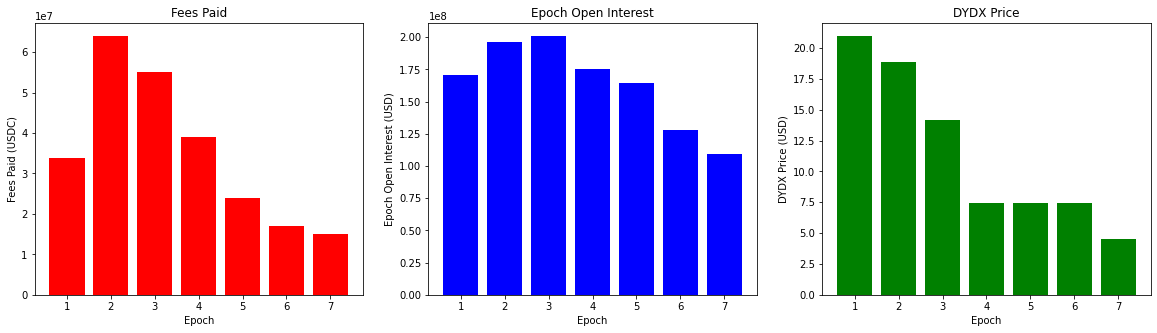

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].bar(df['epoch'], df['fees_epoch_review'], color='red')
axs[0].set_title('Fees Paid')
axs[0].set_ylabel('Fees Paid (USDC)')
axs[0].set_xlabel('Epoch')

axs[1].bar(df['epoch'], df['openInterest'], color='blue')
axs[1].set_title('Epoch Open Interest')
axs[1].set_ylabel('Epoch Open Interest (USD)')
axs[1].set_xlabel('Epoch')

axs[2].bar(df['epoch'], df['close'], color='green')
axs[2].set_title('DYDX Price')
axs[2].set_ylabel('DYDX Price (USD)')
axs[2].set_xlabel('Epoch')

plt.show()

In [103]:
# results = dict()
# for i in range(df.shape[0]):
#     row = df.iloc[i]
#     epoch = row['epoch']
#     if epoch > 4:
#         results[epoch] = find_equilibrium_stk(row['openInterest'], G=row['stakedDYDX'], \
#                 n=row['numTraders'], R=row['totalRewards'], p=row['close'], alpha=0.01, \
#                     num_whales=10, whale_alpha=100)
#     else:
#         results[epoch] = find_equilibrium(row['openInterest'], \
#             n=row['numTraders'], R=row['totalRewards'], p=row['close'], alpha=0.01, \
#                     num_whales=10, whale_alpha=100)

df['expected'] = [sum(results[epoch][1]) for epoch in results] # sum of fees
df

,epoch,epochStart,epochEnd,openInterest,stakedDYDX,weight,totalRewards,fees_api,numTraders,totalTraderScore,metabase_volume,fees_metabase,fees_epoch_review,close,expected
date,,,,,,,,,,,,,,,
2021-08-31,1,2021-08-31,2021-09-28,1.702936e+08,0.000000e+00,0.682,3835616.0,6.054641e+06,9979,64760847,49843854611,2.492193e+07,33900000.0,20.972,5.625145e+07
2021-09-28,2,2021-09-28,2021-10-26,1.963427e+08,0.000000e+00,0.742,3835616.0,8.347642e+07,11175,156288754,93386615022,4.669331e+07,64000000.0,18.849,5.056571e+07
2021-10-26,3,2021-10-26,2021-11-23,2.009800e+08,0.000000e+00,0.688,3835616.0,7.080114e+07,8502,136583326,87346051667,4.367303e+07,55000000.0,14.181,3.802932e+07
2021-11-23,4,2021-11-23,2021-12-21,1.752897e+08,0.000000e+00,0.702,3835616.0,5.289905e+07,6448,91997522,61014239531,3.050712e+07,39000000.0,7.398,1.982622e+07
2021-12-21,5,2021-12-21,2022-01-18,1.646739e+08,2.057430e+07,0.619,3835616.0,2.176282e+06,4876,56500160,39835393021,1.991770e+07,24000000.0,7.415,1.893681e+07
2022-01-18,6,2022-01-18,2022-02-15,1.275790e+08,2.549072e+07,0.630,3835616.0,1.244266e+06,5008,44815330,73237906305,1.830948e+07,17000000.0,7.436,1.899859e+07
2022-02-15,7,2022-02-15,2022-03-15,1.095820e+08,3.652001e+07,0.591,3835616.0,6.404989e+05,5347,40647086,66861025205,1.671526e+07,15000000.0,4.534,1.159669e+07


In [140]:
(15000000.0 - 1.159669e+07) / 15000000.0

0.22688733333333333

In [141]:
(24000000.0-1.893681e+07) / 24000000

0.21096625

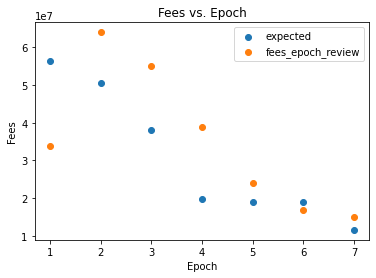

In [115]:
# plt.scatter(df['epoch'], df['fees_api'], label='fees_api')
plt.scatter(df['epoch'], df['expected'], label='expected')
# plt.scatter(df['epoch'], df['fees_metabase'], label='fees_metabase')
plt.scatter(df['epoch'], df['fees_epoch_review'], label='fees_epoch_review')

plt.title("Fees vs. Epoch")
plt.ylabel("Fees")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [87]:
# plt.scatter(df['epoch'].values, np.log10(df['fees'].values), label='fees')
# plt.scatter(df['epoch'].values, np.log10(df['expected'].values), label='expected')

# plt.title("Log Fees vs. Epoch")
# plt.ylabel("log10(fees)")
# plt.xlabel("epoch")
# plt.legend()
# plt.show()

In [138]:
df = pd.read_csv('data/historical.csv')
df = df.set_index(['epoch'])
df_small = df[["openInterest","stakedDYDX","numTraders","totalTraderScore","fees_epoch_review","close"]]
new_col_names = {
    col_name: col_name
    for col_name in df_small.columns.values
}

new_col_names["fees_epoch_review"] = "fees"

df_small = df_small.rename(columns=new_col_names)

cols = df_small.columns.tolist()
cols.remove("fees")
cols = ["fees"] + cols

# Format rows
df_small = df_small[cols]
# df_small["fees"] = df_small["fees"].map('${:,.2f}'.format)
# df_small["openInterest"] = df_small["openInterest"].map('${:,.2f}'.format)
# df_small["close"] = df_small["close"].map('${:,.2f}'.format)
# df_small["openInterest"] = df_small["openInterest"].map(lambda x: float('{:,.2f}'.format(x)))

df_small.to_csv('./data/historical_small.csv')

In [28]:
# row = df.iloc[5]

# d_mkt, f_mkt = find_equilibrium(row['openInterest'], \
#     n=row['numTraders'], R=row['totalRewards'], p=row['close'], alpha=0.01, \
#         num_whales=10, whale_alpha=100)

# _, profit_fast = check_profit(row['totalRewards'], row['close'], row['totalTraderScore'])

# profits = profit_fast(f_mkt, d_mkt)